In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
analytics = load_json_as_dict(os.path.join('data/simulate_circuits/2025_01_28__21_36_14', 'analytics.json'))


In [3]:
r = np.array(analytics['response_time_wrt_species-6'])[:, -1]
idxs = np.where(~np.isinf(r) & ~np.isnan(r))[0]
r[idxs].max()

ys = np.load('data/simulate_circuits/2025_01_28__21_36_14/ys.npy')
ts = np.load('data/simulate_circuits/2025_01_28__21_36_14/ts.npy')
ts0 = np.load('data/simulate_circuits/2025_01_28__21_36_14/ts0.npy')
y00s = np.load('data/simulate_circuits/2025_01_28__21_36_14/y00s.npy')
y0m = np.load('data/simulate_circuits/2025_01_28__21_36_14/y0m.npy')

<Axes: ylabel='Count'>

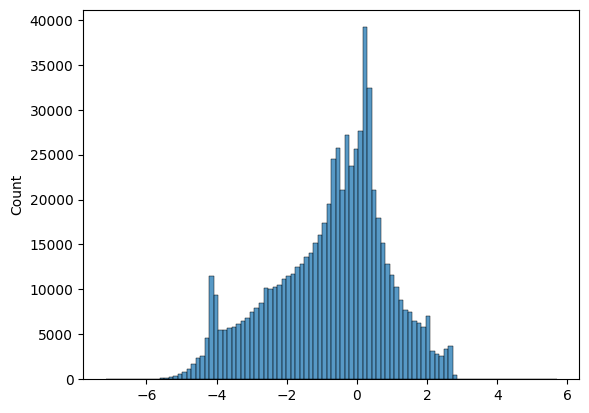

In [ ]:
s = np.array(analytics['Log sensitivity'])[:, -1]


sns.histplot(s, bins=100)



In [ ]:
# !pip install cairosvg
# !apt install libcairo2
import cairosvg

# Load the SVG file
svg_file_path = '../data/adaptation_m0_log_adaptation.svg'

# Convert SVG to PNG
png_file_path = svg_file_path.replace('svg', 'png')
cairosvg.svg2png(url=svg_file_path, write_to=png_file_path, output_width=500, output_height=500)

print(f'SVG file has been converted to PNG and saved at {png_file_path}')

